# MNIST Autoencoder with Vector Quantization (VQ-VAE) and Residual Vector Quantization (RVQ-VAE)

This notebook implements both Vector Quantized Variational Autoencoder (VQ-VAE) and Residual Vector Quantized Variational Autoencoder (RVQ-VAE) for MNIST digit compression and reconstruction. The models use vector quantization at the bottleneck to learn discrete representations of the input images.

## Key Components:
1. **Encoder**: Compresses MNIST images to latent representations
2. **Vector Quantization Layer**: 
   - **VQ**: Discretizes the latent space using a single learnable codebook
   - **RVQ**: Uses multiple quantization layers in sequence, where each layer quantizes the residual from the previous layer
3. **Decoder**: Reconstructs images from quantized representations
4. **Training Loop**: Includes reconstruction loss and vector quantization losses

## RVQ vs VQ:
- **VQ (Vector Quantization)**: Uses a single codebook to quantize the latent representation
- **RVQ (Residual Vector Quantization)**: Uses multiple smaller codebooks in sequence, each quantizing the residual error from the previous layer
- **Benefits of RVQ**: 
  - Better representation capacity with the same total codebook size
  - More efficient use of codebook entries
  - Often better reconstruction quality
  - More gradual quantization process

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [2]:
# F.normalize(model.vq_layer.embedding.weight,dim=1)[0].norm()

In [3]:
class VectorQuantizer(nn.Module):
    """
    Vector Quantization layer for VQ-VAE.
    
    Args:
        num_embeddings: Number of vectors in the codebook
        embedding_dim: Dimension of each codebook vector
        commitment_cost: Weight for commitment loss
    """
    def __init__(self, num_embeddings: int, embedding_dim: int, commitment_cost: float = 0.25):
        super(VectorQuantizer, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # Initialize embedding table
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
        
    
##

    def forward(self, inputs):
        # Convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self.embedding_dim)
        
        # Calculate distances between input and embedding vectors
        # normlize codebook if training
        if self.training:
            self.embedding.weight.data = F.normalize(self.embedding.weight.data, dim=1)


        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embedding.weight.t()))
        
        # Get closest embedding indices
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)
        
        # Loss terms
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        
        # Straight through estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # Convert back to BCHW
        return quantized.permute(0, 3, 1, 2).contiguous(), loss, perplexity

## Understanding Commitment Loss in Vector Quantization

The **commitment loss** is essential for stable training in VQ-VAE. Here's why:

### The Problem Without Commitment Loss:
1. **Gradient Flow Issue**: The quantization operation `z_q = embedding[argmin(distances)]` is not differentiable
2. **Straight-Through Estimator**: We use `z_q = z_e + (quantized - z_e).detach()` to pass gradients
3. **Encoder Drift**: Without commitment loss, the encoder can produce representations that are far from any codebook vector
4. **Codebook Underutilization**: The encoder might ignore the quantization constraint and drift away

### The Two Loss Components:

1. **Codebook Loss** (`q_latent_loss`): 
   - `MSE(quantized, inputs.detach())`
   - Moves codebook vectors **toward** encoder outputs
   - Updates the codebook to better represent the data

2. **Commitment Loss** (`e_latent_loss`):
   - `commitment_cost * MSE(quantized.detach(), inputs)`
   - Forces encoder outputs to **commit** to nearby codebook vectors
   - Prevents encoder from drifting away from quantization constraint

### Mathematical Intuition:
- **Without commitment loss**: Encoder can output anything, codebook tries to follow
- **With commitment loss**: Encoder must consider quantization in its outputs
- **Balance**: `commitment_cost` controls the trade-off between reconstruction quality and quantization constraint

### Typical Values:
- `commitment_cost = 0.25` is commonly used
- Higher values: Stronger quantization constraint, potentially lower reconstruction quality
- Lower values: Weaker constraint, risk of codebook collapse or underutilization

Running commitment loss demonstration...
COMMITMENT LOSS DEMONSTRATION
Training both models for 20 steps...
----------------------------------------
Step  0 | With commitment: Loss=0.2293, Perp=2.7 | Without: Loss=0.1184, Perp=4.5
Step  5 | With commitment: Loss=0.1560, Perp=1.7 | Without: Loss=0.0967, Perp=5.8
Step 10 | With commitment: Loss=0.0954, Perp=2.0 | Without: Loss=0.1387, Perp=3.1
Step 15 | With commitment: Loss=0.0881, Perp=2.0 | Without: Loss=0.0888, Perp=8.1

ANALYSIS RESULTS
Final Reconstruction Loss:
  With commitment:    0.071785
  Without commitment: 0.060002

Final VQ Loss:
  With commitment:    0.012859
  Without commitment: 0.029798

Final Perplexity (higher = better codebook usage):
  With commitment:    1.96
  Without commitment: 8.12

Average Distance to Nearest Codebook Vector:
  With commitment:    0.648834
  Without commitment: 2.052215


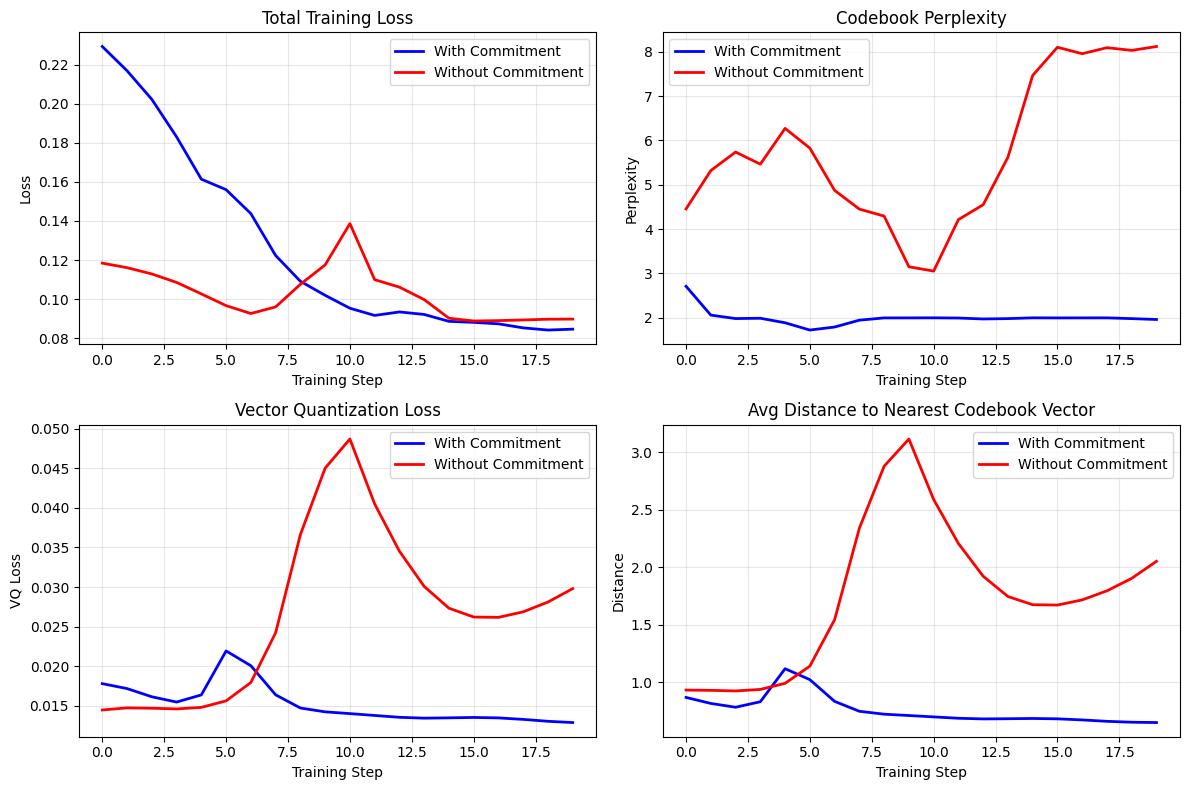


VISUAL COMPARISON


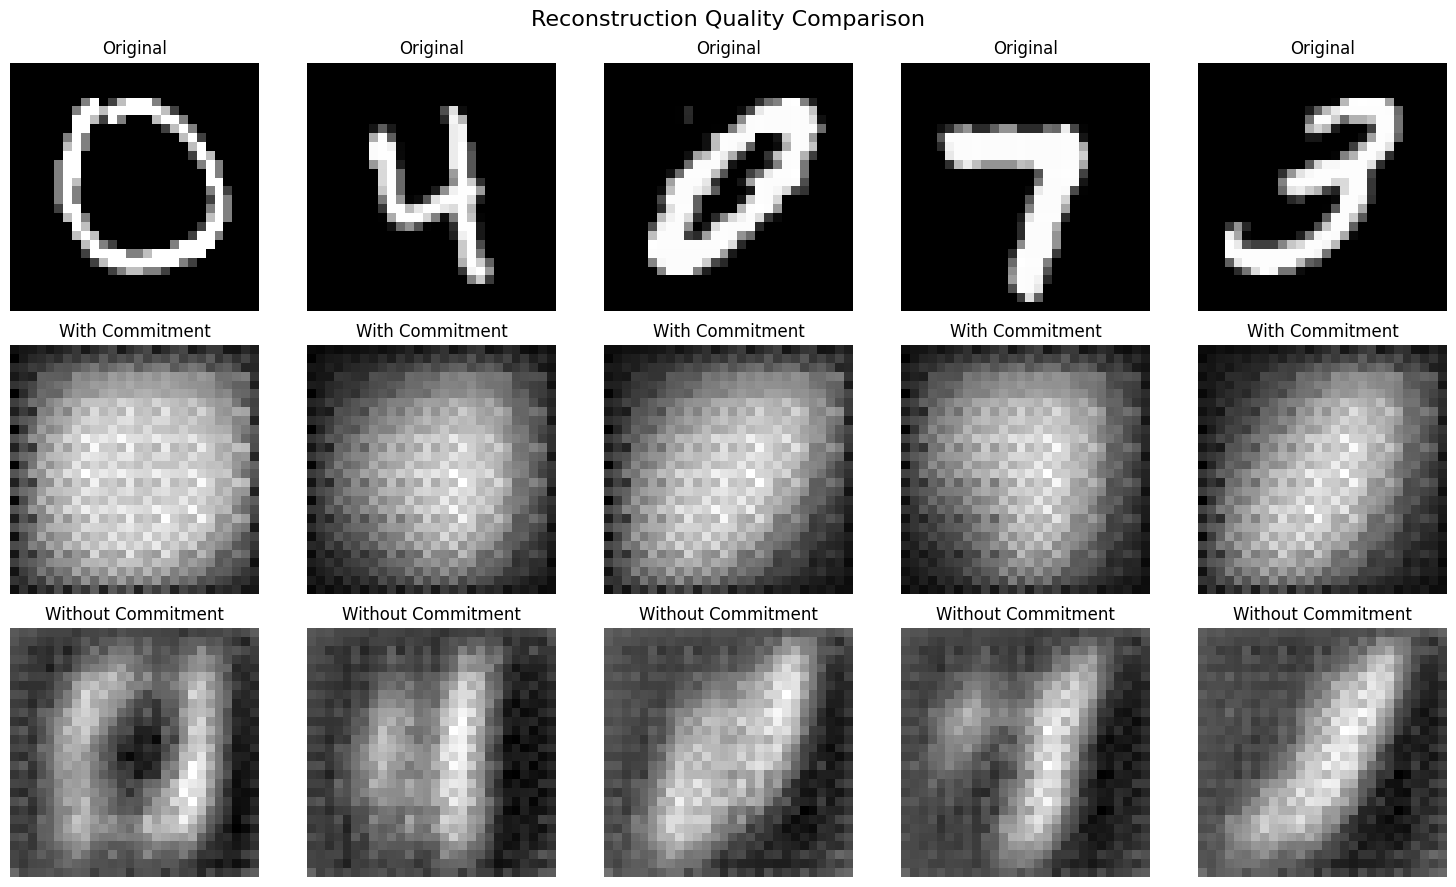

In [41]:
def demonstrate_commitment_loss_effect():
    """Demonstrate the effect of commitment loss on training stability"""
    
    print("="*60)
    print("COMMITMENT LOSS DEMONSTRATION")
    print("="*60)
    
    # Create two models: one with commitment loss, one without
    model_with_commitment = VQVAE(
        num_embeddings=256,
        embedding_dim=64,
        commitment_cost=0.25,  # Standard commitment cost
        hidden_dim=128,
        use_rvq=False
    ).to(device)
    
    model_without_commitment = VQVAE(
        num_embeddings=256,
        embedding_dim=64,
        commitment_cost=0.0,   # No commitment loss
        hidden_dim=128,
        use_rvq=False
    ).to(device)
    
    # Get a batch of data
    data_batch, _ = next(iter(train_loader))
    data_batch = data_batch[:32].to(device)  # Smaller batch for demonstration
    
    # Track metrics for both models
    results = {'with_commitment': [], 'without_commitment': []}
    
    # Short training demonstration
    optimizers = {
        'with_commitment': optim.Adam(model_with_commitment.parameters(), lr=1e-3),
        'without_commitment': optim.Adam(model_without_commitment.parameters(), lr=1e-3)
    }
    
    models = {
        'with_commitment': model_with_commitment,
        'without_commitment': model_without_commitment
    }
    
    print("Training both models for 20 steps...")
    print("-" * 40)
    
    for step in range(20):
        for model_name, model in models.items():
            model.train()
            optimizer = optimizers[model_name]
            
            optimizer.zero_grad()
            
            # Forward pass
            recon_data, vq_loss, perplexity = model(data_batch)
            recon_loss = F.mse_loss(recon_data, data_batch)
            total_loss = recon_loss + vq_loss
            
            # Backward pass
            total_loss.backward()
            optimizer.step()
            
            # Store metrics
            with torch.no_grad():
                # Calculate encoder-codebook distance
                z_e = model.encoder(data_batch)
                if hasattr(model.vq_layer, 'embedding'):  # Regular VQ
                    z_e_flat = z_e.permute(0, 2, 3, 1).contiguous().view(-1, model.vq_layer.embedding_dim)
                    distances = torch.sum(z_e_flat**2, dim=1, keepdim=True) + torch.sum(model.vq_layer.embedding.weight**2, dim=1) - 2 * torch.matmul(z_e_flat, model.vq_layer.embedding.weight.t())
                    min_distances = torch.min(distances, dim=1)[0]
                    avg_distance = min_distances.mean().item()
                else:
                    avg_distance = 0  # For RVQ case
                
                results[model_name].append({
                    'step': step,
                    'recon_loss': recon_loss.item(),
                    'vq_loss': vq_loss.item(),
                    'total_loss': total_loss.item(),
                    'perplexity': perplexity.item(),
                    'avg_distance': avg_distance
                })
        
        if step % 5 == 0:
            print(f"Step {step:2d} | With commitment: Loss={results['with_commitment'][-1]['total_loss']:.4f}, "
                  f"Perp={results['with_commitment'][-1]['perplexity']:.1f} | "
                  f"Without: Loss={results['without_commitment'][-1]['total_loss']:.4f}, "
                  f"Perp={results['without_commitment'][-1]['perplexity']:.1f}")
    
    # Analyze results
    print("\n" + "="*60)
    print("ANALYSIS RESULTS")
    print("="*60)
    
    with_comm = results['with_commitment']
    without_comm = results['without_commitment']
    
    print(f"Final Reconstruction Loss:")
    print(f"  With commitment:    {with_comm[-1]['recon_loss']:.6f}")
    print(f"  Without commitment: {without_comm[-1]['recon_loss']:.6f}")
    
    print(f"\nFinal VQ Loss:")
    print(f"  With commitment:    {with_comm[-1]['vq_loss']:.6f}")
    print(f"  Without commitment: {without_comm[-1]['vq_loss']:.6f}")
    
    print(f"\nFinal Perplexity (higher = better codebook usage):")
    print(f"  With commitment:    {with_comm[-1]['perplexity']:.2f}")
    print(f"  Without commitment: {without_comm[-1]['perplexity']:.2f}")
    
    print(f"\nAverage Distance to Nearest Codebook Vector:")
    print(f"  With commitment:    {with_comm[-1]['avg_distance']:.6f}")
    print(f"  Without commitment: {without_comm[-1]['avg_distance']:.6f}")
    
    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    steps = range(20)
    
    # Total loss
    axes[0,0].plot(steps, [r['total_loss'] for r in with_comm], 'b-', label='With Commitment', linewidth=2)
    axes[0,0].plot(steps, [r['total_loss'] for r in without_comm], 'r-', label='Without Commitment', linewidth=2)
    axes[0,0].set_title('Total Training Loss')
    axes[0,0].set_xlabel('Training Step')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Perplexity
    axes[0,1].plot(steps, [r['perplexity'] for r in with_comm], 'b-', label='With Commitment', linewidth=2)
    axes[0,1].plot(steps, [r['perplexity'] for r in without_comm], 'r-', label='Without Commitment', linewidth=2)
    axes[0,1].set_title('Codebook Perplexity')
    axes[0,1].set_xlabel('Training Step')
    axes[0,1].set_ylabel('Perplexity')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # VQ Loss
    axes[1,0].plot(steps, [r['vq_loss'] for r in with_comm], 'b-', label='With Commitment', linewidth=2)
    axes[1,0].plot(steps, [r['vq_loss'] for r in without_comm], 'r-', label='Without Commitment', linewidth=2)
    axes[1,0].set_title('Vector Quantization Loss')
    axes[1,0].set_xlabel('Training Step')
    axes[1,0].set_ylabel('VQ Loss')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Average distance to codebook
    axes[1,1].plot(steps, [r['avg_distance'] for r in with_comm], 'b-', label='With Commitment', linewidth=2)
    axes[1,1].plot(steps, [r['avg_distance'] for r in without_comm], 'r-', label='Without Commitment', linewidth=2)
    axes[1,1].set_title('Avg Distance to Nearest Codebook Vector')
    axes[1,1].set_xlabel('Training Step')
    axes[1,1].set_ylabel('Distance')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show reconstruction quality comparison
    print("\n" + "="*60)
    print("VISUAL COMPARISON")
    print("="*60)
    
    models['with_commitment'].eval()
    models['without_commitment'].eval()
    
    with torch.no_grad():
        sample_images = data_batch[:5]
        
        recon_with, _, _ = models['with_commitment'](sample_images)
        recon_without, _, _ = models['without_commitment'](sample_images)
    
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    
    for i in range(5):
        # Original
        axes[0, i].imshow(sample_images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # With commitment
        axes[1, i].imshow(recon_with[i].cpu().squeeze(), cmap='gray')
        axes[1, i].set_title('With Commitment')
        axes[1, i].axis('off')
        
        # Without commitment
        axes[2, i].imshow(recon_without[i].cpu().squeeze(), cmap='gray')
        axes[2, i].set_title('Without Commitment')
        axes[2, i].axis('off')
    
    plt.suptitle('Reconstruction Quality Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return models, results

# Run the demonstration
print("Running commitment loss demonstration...")
models_demo, results_demo = demonstrate_commitment_loss_effect()

COMMITMENT LOSS: SIMPLE 2D ANALOGY


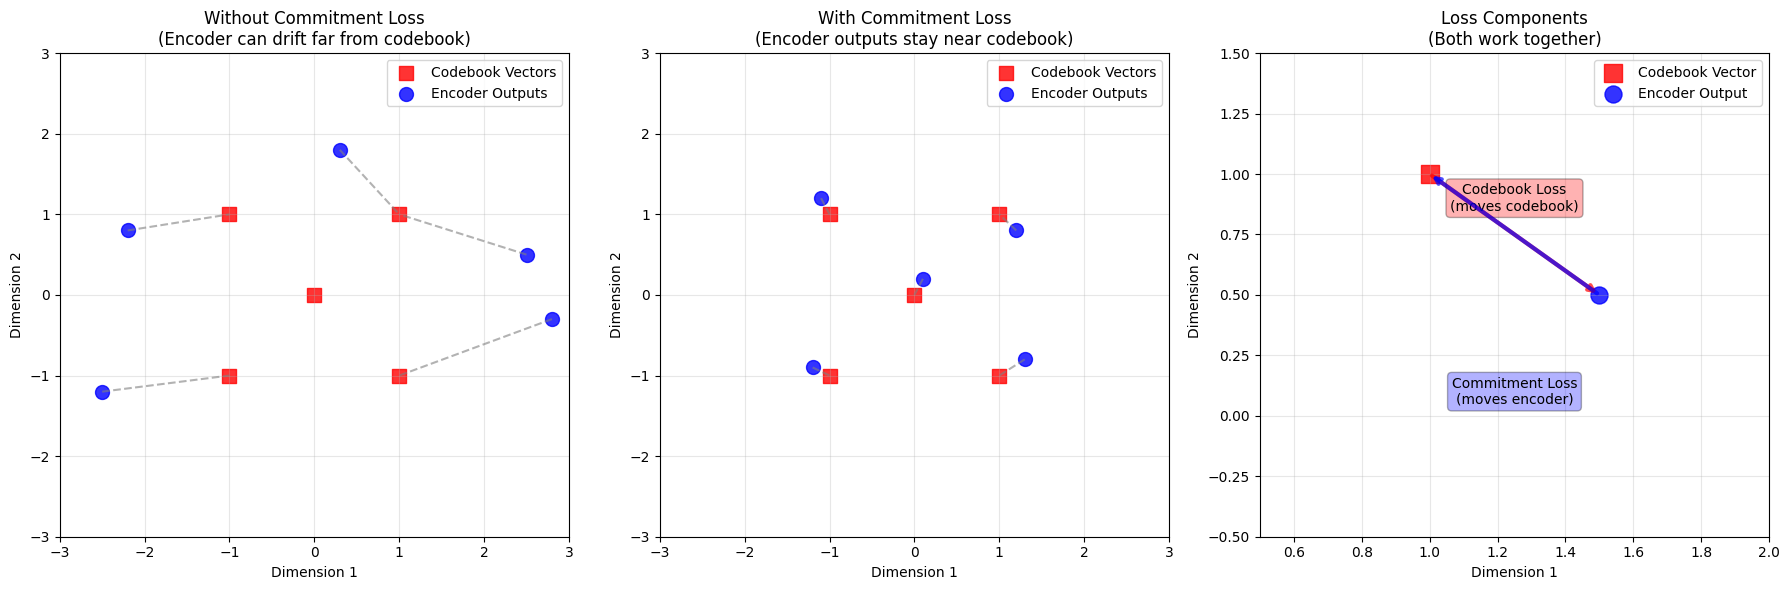


Key Insights:
1. WITHOUT commitment loss: Encoder can output anything, codebook chases it
2. WITH commitment loss: Encoder is forced to stay near existing codebook vectors
3. This creates a stable training dynamic where both encoder and codebook cooperate
4. The commitment_cost parameter controls how strongly we enforce this constraint


In [40]:
def visualize_commitment_loss_concept():
    """Create a simple 2D visualization to explain commitment loss concept"""
    
    print("="*60)
    print("COMMITMENT LOSS: SIMPLE 2D ANALOGY")
    print("="*60)
    
    # Create a simple 2D example
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Scenario 1: Without commitment loss
    ax = axes[0]
    
    # Codebook vectors (fixed points)
    codebook_points = np.array([[1, 1], [1, -1], [-1, 1], [-1, -1], [0, 0]])
    
    # Encoder outputs (can be anywhere without commitment loss)
    encoder_outputs_no_commit = np.array([[2.5, 0.5], [2.8, -0.3], [-2.2, 0.8], [-2.5, -1.2], [0.3, 1.8]])
    
    # Plot codebook
    ax.scatter(codebook_points[:, 0], codebook_points[:, 1], 
              c='red', s=100, marker='s', label='Codebook Vectors', alpha=0.8)
    
    # Plot encoder outputs
    ax.scatter(encoder_outputs_no_commit[:, 0], encoder_outputs_no_commit[:, 1], 
              c='blue', s=100, marker='o', label='Encoder Outputs', alpha=0.8)
    
    # Draw lines showing quantization (assignment to nearest codebook vector)
    for i, enc_out in enumerate(encoder_outputs_no_commit):
        # Find nearest codebook vector
        distances = np.linalg.norm(codebook_points - enc_out, axis=1)
        nearest_idx = np.argmin(distances)
        ax.plot([enc_out[0], codebook_points[nearest_idx, 0]], 
               [enc_out[1], codebook_points[nearest_idx, 1]], 
               'gray', linestyle='--', alpha=0.6)
    
    ax.set_title('Without Commitment Loss\n(Encoder can drift far from codebook)', fontsize=12)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    
    # Scenario 2: With commitment loss
    ax = axes[1]
    
    # Encoder outputs (pulled closer to codebook due to commitment loss)
    encoder_outputs_with_commit = np.array([[1.2, 0.8], [1.3, -0.8], [-1.1, 1.2], [-1.2, -0.9], [0.1, 0.2]])
    
    # Plot codebook
    ax.scatter(codebook_points[:, 0], codebook_points[:, 1], 
              c='red', s=100, marker='s', label='Codebook Vectors', alpha=0.8)
    
    # Plot encoder outputs
    ax.scatter(encoder_outputs_with_commit[:, 0], encoder_outputs_with_commit[:, 1], 
              c='blue', s=100, marker='o', label='Encoder Outputs', alpha=0.8)
    
    # Draw lines showing quantization
    for i, enc_out in enumerate(encoder_outputs_with_commit):
        distances = np.linalg.norm(codebook_points - enc_out, axis=1)
        nearest_idx = np.argmin(distances)
        ax.plot([enc_out[0], codebook_points[nearest_idx, 0]], 
               [enc_out[1], codebook_points[nearest_idx, 1]], 
               'gray', linestyle='--', alpha=0.6)
    
    ax.set_title('With Commitment Loss\n(Encoder outputs stay near codebook)', fontsize=12)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    
    # Scenario 3: Loss components visualization
    ax = axes[2]
    
    # Show loss components as arrows
    enc_point = np.array([1.5, 0.5])
    codebook_point = np.array([1.0, 1.0])
    
    # Plot points
    ax.scatter(codebook_point[0], codebook_point[1], c='red', s=150, marker='s', 
              label='Codebook Vector', alpha=0.8)
    ax.scatter(enc_point[0], enc_point[1], c='blue', s=150, marker='o', 
              label='Encoder Output', alpha=0.8)
    
    # Codebook loss arrow (moves codebook toward encoder)
    ax.annotate('', xy=enc_point, xytext=codebook_point,
                arrowprops=dict(arrowstyle='->', color='red', lw=3, alpha=0.7))
    ax.text(1.25, 0.9, 'Codebook Loss\n(moves codebook)', ha='center', va='center', 
            bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
    
    # Commitment loss arrow (moves encoder toward codebook)
    ax.annotate('', xy=codebook_point, xytext=enc_point,
                arrowprops=dict(arrowstyle='->', color='blue', lw=3, alpha=0.7))
    ax.text(1.25, 0.1, 'Commitment Loss\n(moves encoder)', ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='blue', alpha=0.3))
    
    ax.set_title('Loss Components\n(Both work together)', fontsize=12)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.5, 2.0)
    ax.set_ylim(-0.5, 1.5)
    
    plt.tight_layout()
    plt.show()
    
    print("\nKey Insights:")
    print("1. WITHOUT commitment loss: Encoder can output anything, codebook chases it")
    print("2. WITH commitment loss: Encoder is forced to stay near existing codebook vectors")
    print("3. This creates a stable training dynamic where both encoder and codebook cooperate")
    print("4. The commitment_cost parameter controls how strongly we enforce this constraint")

# Run the visualization
visualize_commitment_loss_concept()

In [4]:
class ResidualVectorQuantizer(nn.Module):
    """
    Residual Vector Quantization layer for RVQ-VAE.
    Uses multiple quantization layers in sequence, where each layer quantizes 
    the residual from the previous layer.
    
    Args:
        num_quantizers: Number of quantization layers (depth)
        num_embeddings: Number of vectors in each codebook
        embedding_dim: Dimension of each codebook vector
        commitment_cost: Weight for commitment loss
    """
    def __init__(self, num_quantizers: int, num_embeddings: int, embedding_dim: int, commitment_cost: float = 0.25):
        super(ResidualVectorQuantizer, self).__init__()
        
        self.num_quantizers = num_quantizers
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # Create multiple VQ layers
        self.quantizers = nn.ModuleList([
            VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
            for _ in range(num_quantizers)
        ])
    
    def forward(self, inputs):
        # Convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        quantized_list = []
        residual = inputs
        total_loss = 0
        total_perplexity = 0
        
        # Apply quantization layers sequentially
        for i, quantizer in enumerate(self.quantizers):
            # Quantize the current residual
            residual_bchw = residual.permute(0, 3, 1, 2).contiguous()
            quantized_bchw, vq_loss, perplexity = quantizer(residual_bchw)
            quantized = quantized_bchw.permute(0, 2, 3, 1).contiguous()
            
            # Store quantized vector
            quantized_list.append(quantized)
            
            # Calculate new residual for next layer
            residual = residual - quantized.detach()
            
            # Accumulate losses
            total_loss += vq_loss
            total_perplexity += perplexity
        
        # Sum all quantized representations
        final_quantized = sum(quantized_list)
        
        # Straight through estimator for gradient flow
        final_quantized = inputs + (final_quantized - inputs).detach()
        
        # Average perplexity across layers
        avg_perplexity = total_perplexity / self.num_quantizers
        
        # Convert back to BCHW
        return final_quantized.permute(0, 3, 1, 2).contiguous(), total_loss, avg_perplexity
    
    def get_codebook_usage(self, inputs):
        """Get codebook usage statistics for each quantization layer"""
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        residual = inputs
        usage_stats = []
        
        for quantizer in self.quantizers:
            residual_bchw = residual.permute(0, 3, 1, 2).contiguous()
            
            # Get quantizer internal calculations
            residual_bhwc = residual_bchw.permute(0, 2, 3, 1).contiguous()
            flat_input = residual_bhwc.view(-1, self.embedding_dim)
            
            distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                        + torch.sum(quantizer.embedding.weight**2, dim=1)
                        - 2 * torch.matmul(flat_input, quantizer.embedding.weight.t()))
            
            encoding_indices = torch.argmin(distances, dim=1)
            unique_codes = torch.unique(encoding_indices)
            
            usage_stats.append({
                'unique_codes': len(unique_codes),
                'usage_percentage': len(unique_codes) / self.num_embeddings * 100
            })
            
            # Calculate quantized for next residual
            encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
            encodings.scatter_(1, encoding_indices.unsqueeze(1), 1)
            quantized = torch.matmul(encodings, quantizer.embedding.weight).view(residual_bhwc.shape)
            
            residual = residual - quantized.detach()
        
        return usage_stats

In [5]:
class Encoder(nn.Module):
    """
    Encoder network for VQ-VAE.
    Compresses 28x28 MNIST images to latent representations.
    """
    def __init__(self, in_channels: int = 1, hidden_dim: int = 128, embedding_dim: int = 64):
        super(Encoder, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # First conv block: 28x28 -> 14x14
            nn.Conv2d(in_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # Second conv block: 14x14 -> 7x7
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # Third conv block: 7x7 -> 7x7 (same size)
            nn.Conv2d(64, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # Final conv to embedding dimension
            nn.Conv2d(hidden_dim, embedding_dim, kernel_size=1),
        )
        
    def forward(self, x):
        return self.conv_layers(x)

In [6]:
class Decoder(nn.Module):
    """
    Decoder network for VQ-VAE.
    Reconstructs 28x28 MNIST images from quantized latent representations.
    """
    def __init__(self, embedding_dim: int = 64, hidden_dim: int = 128, out_channels: int = 1):
        super(Decoder, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # First conv: embedding_dim -> hidden_dim
            nn.Conv2d(embedding_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # Second conv: maintain hidden_dim
            nn.Conv2d(hidden_dim, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # First upsampling: 7x7 -> 14x14
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # Second upsampling: 14x14 -> 28x28
            nn.ConvTranspose2d(32, out_channels, kernel_size=4, stride=2, padding=1),
            # nn.Sigmoid()  # Output values between 0 and 1
        )
        
    def forward(self, x):
        return self.conv_layers(x)

In [7]:
class VQVAE(nn.Module):
    """
    Complete VQ-VAE model combining Encoder, VectorQuantizer/ResidualVectorQuantizer, and Decoder.
    Supports both regular VQ and Residual VQ modes.
    """
    def __init__(self, 
                 num_embeddings: int = 512, 
                 embedding_dim: int = 64, 
                 commitment_cost: float = 0.25,
                 hidden_dim: int = 128,
                 use_rvq: bool = False,
                 num_quantizers: int = 4):
        super(VQVAE, self).__init__()
        
        self.use_rvq = use_rvq
        self.encoder = Encoder(embedding_dim=embedding_dim, hidden_dim=hidden_dim)
        
        if use_rvq:
            self.vq_layer = ResidualVectorQuantizer(
                num_quantizers=num_quantizers,
                num_embeddings=num_embeddings, 
                embedding_dim=embedding_dim, 
                commitment_cost=commitment_cost
            )
        else:
            self.vq_layer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        
        self.decoder = Decoder(embedding_dim=embedding_dim, hidden_dim=hidden_dim)
        
    def forward(self, x):
        # Encode
        z_e = self.encoder(x)
        
        # Vector quantize (either VQ or RVQ)
        z_q, vq_loss, perplexity = self.vq_layer(z_e)
        
        # Decode
        x_recon = self.decoder(z_q)
        
        return x_recon, vq_loss, perplexity
    
    def encode(self, x):
        """Encode input to quantized latent codes"""
        z_e = self.encoder(x)
        z_q, _, _ = self.vq_layer(z_e)
        return z_q
    
    def decode(self, z_q):
        """Decode quantized latent codes to reconstruction"""
        return self.decoder(z_q)
    
    def get_quantization_info(self):
        """Get information about the quantization method used"""
        if self.use_rvq:
            return {
                'type': 'RVQ',
                'num_quantizers': self.vq_layer.num_quantizers,
                'num_embeddings': self.vq_layer.num_embeddings,
                'embedding_dim': self.vq_layer.embedding_dim,
                'total_codebook_size': self.vq_layer.num_quantizers * self.vq_layer.num_embeddings
            }
        else:
            return {
                'type': 'VQ',
                'num_embeddings': self.vq_layer.num_embeddings,
                'embedding_dim': self.vq_layer.embedding_dim,
                'total_codebook_size': self.vq_layer.num_embeddings
            }

Training samples: 60000
Test samples: 10000
Batch size: 128


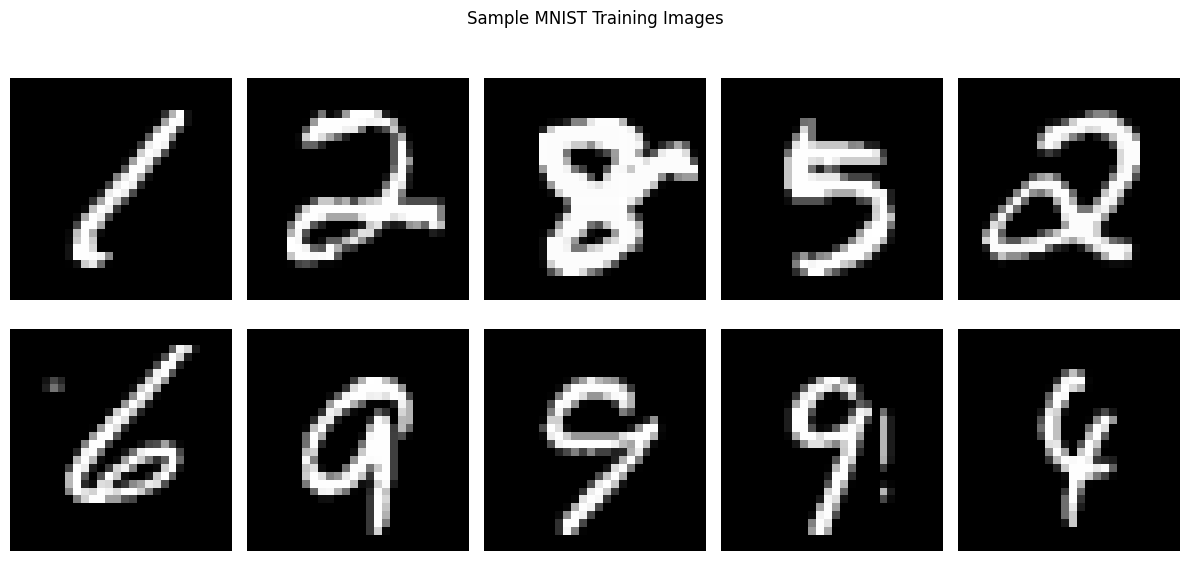

In [8]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    # Note: MNIST is already normalized to [0,1], no need for additional normalization
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")

# Visualize some sample images
def show_images(images, title="Sample Images", nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].squeeze(), cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Show sample training images
sample_batch, _ = next(iter(train_loader))
show_images(sample_batch[:10], "Sample MNIST Training Images")

In [9]:
# Model Comparison: VQ vs RVQ

def create_and_compare_models():
    """Create both VQ and RVQ models for comparison"""
    
    # VQ-VAE model (original)
    vq_model = VQVAE(
        num_embeddings=512,
        embedding_dim=64,
        commitment_cost=0.25,
        hidden_dim=128,
        use_rvq=False
    ).to(device)
    
    # RVQ-VAE model (residual quantization)
    rvq_model = VQVAE(
        num_embeddings=128,  # Smaller per-layer codebook since we have multiple layers
        embedding_dim=64,
        commitment_cost=0.25,
        hidden_dim=128,
        use_rvq=True,
        num_quantizers=4  # Use 4 quantization layers
    ).to(device)
    
    print("VQ Model Configuration:")
    vq_info = vq_model.get_quantization_info()
    for key, value in vq_info.items():
        print(f"  {key}: {value}")
    
    print(f"\nVQ Model Parameters: {sum(p.numel() for p in vq_model.parameters()):,}")
    
    print("\nRVQ Model Configuration:")
    rvq_info = rvq_model.get_quantization_info()
    for key, value in rvq_info.items():
        print(f"  {key}: {value}")
    
    print(f"\nRVQ Model Parameters: {sum(p.numel() for p in rvq_model.parameters()):,}")
    
    # Test forward pass for both models
    with torch.no_grad():
        test_input = torch.randn(4, 1, 28, 28).to(device)
        
        # VQ model
        vq_output, vq_loss, vq_perp = vq_model(test_input)
        print(f"\nVQ Model Test:")
        print(f"  Input shape: {test_input.shape}")
        print(f"  Output shape: {vq_output.shape}")
        print(f"  VQ loss: {vq_loss.item():.4f}")
        print(f"  Perplexity: {vq_perp.item():.4f}")
        
        # RVQ model
        rvq_output, rvq_loss, rvq_perp = rvq_model(test_input)
        print(f"\nRVQ Model Test:")
        print(f"  Input shape: {test_input.shape}")
        print(f"  Output shape: {rvq_output.shape}")
        print(f"  VQ loss: {rvq_loss.item():.4f}")
        print(f"  Perplexity: {rvq_perp.item():.4f}")
    
    return vq_model, rvq_model

# Create and compare models
vq_model, rvq_model = create_and_compare_models()

VQ Model Configuration:
  type: VQ
  num_embeddings: 512
  embedding_dim: 64
  total_codebook_size: 512

VQ Model Parameters: 329,217

RVQ Model Configuration:
  type: RVQ
  num_quantizers: 4
  num_embeddings: 128
  embedding_dim: 64
  total_codebook_size: 512

RVQ Model Parameters: 329,217

VQ Model Test:
  Input shape: torch.Size([4, 1, 28, 28])
  Output shape: torch.Size([4, 1, 28, 28])
  VQ loss: 0.0167
  Perplexity: 5.3468

RVQ Model Test:
  Input shape: torch.Size([4, 1, 28, 28])
  Output shape: torch.Size([4, 1, 28, 28])
  VQ loss: 0.1075
  Perplexity: 11.1606


Select quantization method:
1. VQ (Vector Quantization)
2. RVQ (Residual Vector Quantization)

COMPARISON TRAINING (Limited epochs for demo)
Training VQ-VAE model...
Model type: VQ
Total parameters: 329,217


Epoch 1/3: Loss = 0.1210
Epoch 2/3: Loss = 0.2013
Epoch 3/3: Loss = 0.1037

------------------------------------------------------------
Training RVQ-VAE model...
Model type: RVQ
Total parameters: 329,217
Epoch 1/3: Loss = 0.1213
Epoch 2/3: Loss = 0.0793
Epoch 3/3: Loss = 0.0652


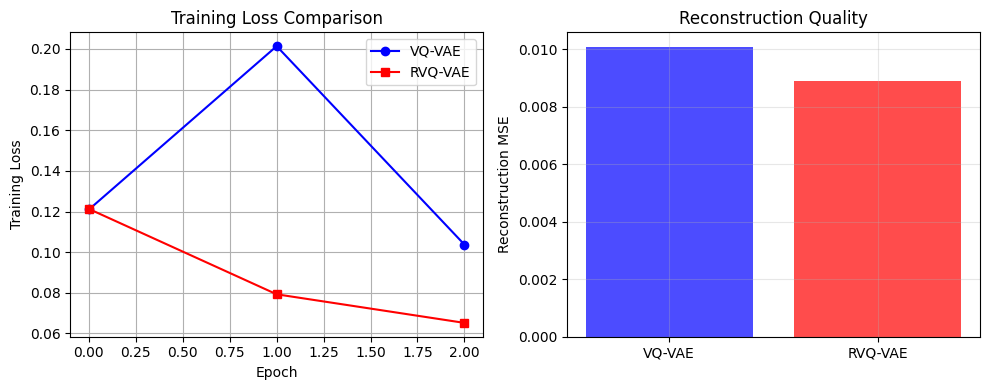


Final Results:
VQ-VAE Reconstruction MSE: 0.010081
RVQ-VAE Reconstruction MSE: 0.008884

RVQ Codebook Usage Analysis:
--------------------------------------------------
Layer 1:
  Average unique codes used: 1.0 / 128
  Average usage percentage: 0.8%
Layer 2:
  Average unique codes used: 9.3 / 128
  Average usage percentage: 7.3%
Layer 3:
  Average unique codes used: 39.0 / 128
  Average usage percentage: 30.5%
Layer 4:
  Average unique codes used: 83.5 / 128
  Average usage percentage: 65.2%

Total effective codebook size: 512


In [10]:
def analyze_rvq_codebook_usage(model, test_loader, device):
    """Analyze codebook usage for RVQ model across all quantization layers"""
    if not model.use_rvq:
        print("This function is only for RVQ models")
        return
    
    model.eval()
    
    # Collect statistics across all test data
    layer_stats = []
    
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            if batch_idx >= 10:  # Limit to first 10 batches for speed
                break
                
            data = data.to(device)
            z_e = model.encoder(data)
            
            # Get usage stats for this batch
            batch_stats = model.vq_layer.get_codebook_usage(z_e)
            
            if not layer_stats:
                layer_stats = [[] for _ in range(len(batch_stats))]
            
            for layer_idx, stats in enumerate(batch_stats):
                layer_stats[layer_idx].append(stats)
    
    # Aggregate statistics
    print("RVQ Codebook Usage Analysis:")
    print("-" * 50)
    
    for layer_idx, stats_list in enumerate(layer_stats):
        avg_unique = np.mean([s['unique_codes'] for s in stats_list])
        avg_percentage = np.mean([s['usage_percentage'] for s in stats_list])
        
        print(f"Layer {layer_idx + 1}:")
        print(f"  Average unique codes used: {avg_unique:.1f} / {model.vq_layer.num_embeddings}")
        print(f"  Average usage percentage: {avg_percentage:.1f}%")
    
    print(f"\nTotal effective codebook size: {model.vq_layer.num_quantizers * model.vq_layer.num_embeddings}")

def train_with_model_selection(use_rvq=False, num_epochs=10):
    """Train either VQ or RVQ model based on selection"""
    
    # Create model based on selection
    if use_rvq:
        print("Training RVQ-VAE model...")
        model = VQVAE(
            num_embeddings=128,  # Smaller per-layer codebook
            embedding_dim=64,
            commitment_cost=0.25,
            hidden_dim=128,
            use_rvq=True,
            num_quantizers=4
        ).to(device)
    else:
        print("Training VQ-VAE model...")
        model = VQVAE(
            num_embeddings=512,  # Standard codebook size
            embedding_dim=64,
            commitment_cost=0.25,
            hidden_dim=128,
            use_rvq=False
        ).to(device)
    
    # Print model info
    model_info = model.get_quantization_info()
    print(f"Model type: {model_info['type']}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # Training loop
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            if batch_idx >= 50:  # Limit batches for demo
                break
                
            data = data.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            recon_data, vq_loss, perplexity = model(data)
            recon_loss = F.mse_loss(recon_data, data)
            
            total_loss = recon_loss + vq_loss
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()
        
        avg_loss = epoch_loss / min(50, len(train_loader))
        train_losses.append(avg_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}: Loss = {avg_loss:.4f}")
    
    return model, train_losses

# Example usage - you can switch between VQ and RVQ
print("Select quantization method:")
print("1. VQ (Vector Quantization)")
print("2. RVQ (Residual Vector Quantization)")

# For demonstration, let's show both
print("\n" + "="*60)
print("COMPARISON TRAINING (Limited epochs for demo)")
print("="*60)

# Train VQ model
vq_model_trained, vq_losses = train_with_model_selection(use_rvq=False, num_epochs=3)

print("\n" + "-"*60)

# Train RVQ model  
rvq_model_trained, rvq_losses = train_with_model_selection(use_rvq=True, num_epochs=3)

# Plot comparison
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(vq_losses, 'b-', label='VQ-VAE', marker='o')
plt.plot(rvq_losses, 'r-', label='RVQ-VAE', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

# Test reconstructions
plt.subplot(1, 2, 2)
test_data, _ = next(iter(test_loader))
test_data = test_data[:4].to(device)

with torch.no_grad():
    vq_recon, _, _ = vq_model_trained(test_data)
    rvq_recon, _, _ = rvq_model_trained(test_data)
    
    vq_mse = F.mse_loss(vq_recon, test_data).item()
    rvq_mse = F.mse_loss(rvq_recon, test_data).item()

plt.bar(['VQ-VAE', 'RVQ-VAE'], [vq_mse, rvq_mse], color=['blue', 'red'], alpha=0.7)
plt.ylabel('Reconstruction MSE')
plt.title('Reconstruction Quality')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"VQ-VAE Reconstruction MSE: {vq_mse:.6f}")
print(f"RVQ-VAE Reconstruction MSE: {rvq_mse:.6f}")

# Analyze RVQ codebook usage if we have an RVQ model
if rvq_model_trained.use_rvq:
    print(f"\n{'='*60}")
    analyze_rvq_codebook_usage(rvq_model_trained, test_loader, device)

In [26]:
# Model initialization
model = VQVAE(
    num_embeddings=512,    # Size of the codebook
    embedding_dim=64,      # Dimension of each codebook vector
    commitment_cost=0.0,  # Weight for commitment loss
    hidden_dim=128         # Hidden dimension in encoder/decoder
).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Print model information
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model: {model}")

# Test forward pass
with torch.no_grad():
    test_input = torch.randn(1, 1, 28, 28).to(device)
    test_output, test_vq_loss, test_perplexity = model(test_input)
    print(f"\nTest forward pass:")
    print(f"Input shape: {test_input.shape}")
    print(f"Output shape: {test_output.shape}")
    print(f"VQ loss: {test_vq_loss.item():.4f}")
    print(f"Perplexity: {test_perplexity.item():.4f}")

Total parameters: 329,217
Trainable parameters: 329,217
Model: VQVAE(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (vq_layer): VectorQuantizer(
    (embedding): Embedding(512, 64)
  )
  (decoder): Decoder(
    (conv_layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(3

In [27]:
inputs = next(iter(train_loader))[0].to(device)


In [28]:
e= model.encoder(inputs)

In [29]:
e.shape

torch.Size([128, 64, 7, 7])

In [30]:
self = model.vq_layer
inputs = e.permute(0, 2, 3, 1).contiguous()
input_shape = inputs.shape

# Flatten input
flat_input = inputs.view(-1, self.embedding_dim)

# Calculate distances between input and embedding vectors
distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
            + torch.sum(self.embedding.weight**2, dim=1)
            - 2 * torch.matmul(flat_input, self.embedding.weight.t()))

# Get closest embedding indices
encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
encodings.scatter_(1, encoding_indices, 1)

# Quantize and unflatten
quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)

# Loss terms
e_latent_loss = F.mse_loss(quantized.detach(), inputs)
q_latent_loss = F.mse_loss(quantized, inputs.detach())
loss = q_latent_loss + self.commitment_cost * e_latent_loss

# Straight through estimator
quantized = inputs + (quantized - inputs).detach()
avg_probs = torch.mean(encodings, dim=0)
perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

# Convert back to BCHW
o =  quantized.permute(0, 3, 1, 2).contiguous(), loss, perplexity

In [16]:
# avg_probs

In [31]:
flat_input.shape

torch.Size([6272, 64])

In [32]:
encodings.shape

torch.Size([6272, 512])

In [33]:
model

VQVAE(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (vq_layer): VectorQuantizer(
    (embedding): Embedding(512, 64)
  )
  (decoder): Decoder(
    (conv_layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )


In [34]:
def train_epoch(model, train_loader, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_vq_loss = 0
    total_perplexity = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        recon_data, vq_loss, perplexity = model(data)
        
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(recon_data, data)
        
        # Total loss
        loss = recon_loss  + vq_loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Accumulate metrics
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_vq_loss += vq_loss.item()
        total_perplexity += perplexity.item()
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}: '
                  f'Loss: {loss.item():.4f}, '
                  f'Recon: {recon_loss.item():.4f}, '
                  f'VQ: {vq_loss.item():.4f}, '
                  f'Perplexity: {perplexity.item():.2f}')
    
    # Return average metrics
    num_batches = len(train_loader)
    return (total_loss / num_batches, 
            total_recon_loss / num_batches, 
            total_vq_loss / num_batches, 
            total_perplexity / num_batches)

In [35]:
def evaluate(model, test_loader, device):
    """Evaluate the model on test set"""
    model.eval()
    total_loss = 0
    total_recon_loss = 0
    total_vq_loss = 0
    total_perplexity = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            
            # Forward pass
            recon_data, vq_loss, perplexity = model(data)
            
            # Reconstruction loss
            recon_loss = F.mse_loss(recon_data, data)
            
            # Total loss
            loss = recon_loss + vq_loss
            
            # Accumulate metrics
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_vq_loss += vq_loss.item()
            total_perplexity += perplexity.item()
    
    # Return average metrics
    num_batches = len(test_loader)
    return (total_loss / num_batches, 
            total_recon_loss / num_batches, 
            total_vq_loss / num_batches, 
            total_perplexity / num_batches)

Starting training...
------------------------------------------------------------

Epoch 1/10
----------------------------------------


Batch 0/469: Loss: 0.1116, Recon: 0.0977, VQ: 0.0139, Perplexity: 4.91
Batch 100/469: Loss: 24250922.0000, Recon: 0.0645, VQ: 24250922.0000, Perplexity: 1.47
Batch 100/469: Loss: 24250922.0000, Recon: 0.0645, VQ: 24250922.0000, Perplexity: 1.47
Batch 200/469: Loss: 80485400576.0000, Recon: 0.0612, VQ: 80485400576.0000, Perplexity: 1.45
Batch 200/469: Loss: 80485400576.0000, Recon: 0.0612, VQ: 80485400576.0000, Perplexity: 1.45
Batch 300/469: Loss: 1272747524096.0000, Recon: 0.0472, VQ: 1272747524096.0000, Perplexity: 3.01
Batch 300/469: Loss: 1272747524096.0000, Recon: 0.0472, VQ: 1272747524096.0000, Perplexity: 3.01
Batch 400/469: Loss: 1299855048704.0000, Recon: 0.0415, VQ: 1299855048704.0000, Perplexity: 2.78
Batch 400/469: Loss: 1299855048704.0000, Recon: 0.0415, VQ: 1299855048704.0000, Perplexity: 2.78

Epoch 1 Summary:
Train - Loss: 574743199925.6382, Recon: 0.0547, VQ: 574743199925.6256, Perp: 2.26
Test  - Loss: 1001754291757.3671, Recon: 0.0374, VQ: 1001754291757.3671, Perp: 1.

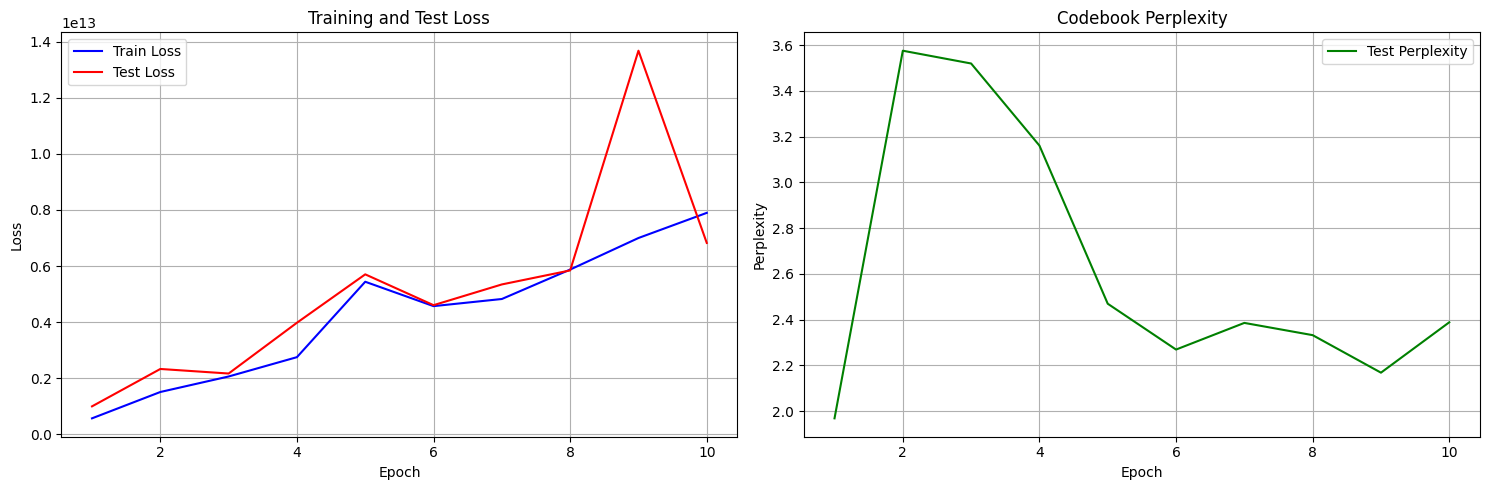

In [36]:
# Training loop
num_epochs = 10
train_losses = []
test_losses = []
perplexities = []

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 40)
    
    # Train for one epoch
    train_loss, train_recon, train_vq, train_perp = train_epoch(
        model, train_loader, optimizer, device
    )
    
    # Evaluate on test set
    test_loss, test_recon, test_vq, test_perp = evaluate(
        model, test_loader, device
    )
    
    # Store metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    perplexities.append(test_perp)
    
    # Print epoch summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"Train - Loss: {train_loss:.4f}, Recon: {train_recon:.4f}, VQ: {train_vq:.4f}, Perp: {train_perp:.2f}")
    print(f"Test  - Loss: {test_loss:.4f}, Recon: {test_recon:.4f}, VQ: {test_vq:.4f}, Perp: {test_perp:.2f}")

print("\nTraining completed!")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss')
ax1.plot(range(1, num_epochs + 1), test_losses, 'r-', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True)

# Perplexity curve
ax2.plot(range(1, num_epochs + 1), perplexities, 'g-', label='Test Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.set_title('Codebook Perplexity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Visualizing reconstructions...


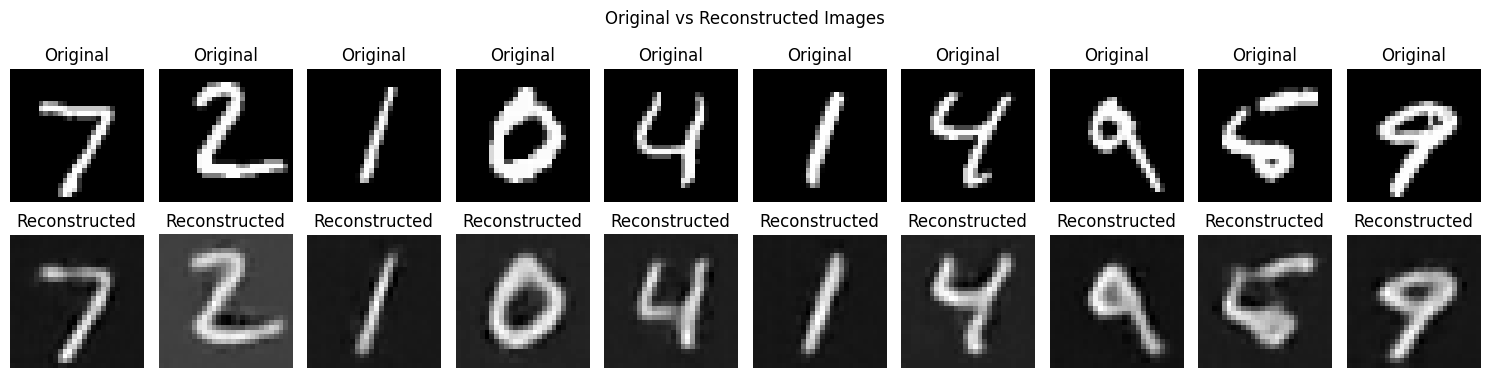


Analyzing codebook usage...
Codebook Analysis:
Total codebook size: 512
Codes used: 3 (0.6%)
Most used code frequency: 254922
Least used code frequency: 0
Codebook Analysis:
Total codebook size: 512
Codes used: 3 (0.6%)
Most used code frequency: 254922
Least used code frequency: 0


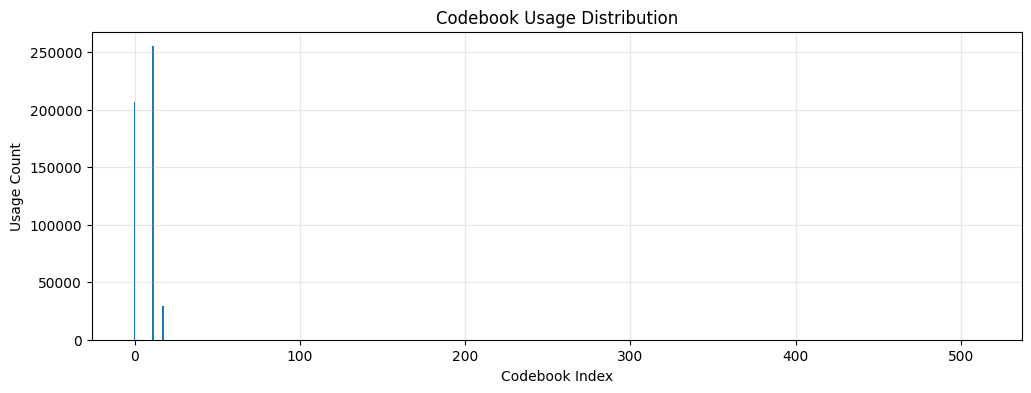

In [37]:
def visualize_reconstructions(model, test_loader, device, num_samples=10):
    """Visualize original images and their reconstructions"""
    model.eval()
    
    # Get a batch of test images
    data, _ = next(iter(test_loader))
    data = data[:num_samples].to(device)
    
    with torch.no_grad():
        reconstructions, _, _ = model(data)
    
    # Move to CPU for plotting
    originals = data.cpu()
    reconstructions = reconstructions.cpu()
    
    # Create comparison plot
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))
    
    for i in range(num_samples):
        # Original images
        axes[0, i].imshow(originals[i].squeeze(), cmap='gray')
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # Reconstructed images
        axes[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')
    
    plt.suptitle('Original vs Reconstructed Images')
    plt.tight_layout()
    plt.show()

def analyze_codebook_usage(model, test_loader, device):
    """Analyze how much of the codebook is being used"""
    model.eval()
    
    # Collect all encoding indices
    encoding_indices = []
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            
            # Get encoded representation
            z_e = model.encoder(data)
            
            # Get quantized representation and indices
            z_e_permuted = z_e.permute(0, 2, 3, 1).contiguous()
            flat_input = z_e_permuted.view(-1, model.vq_layer.embedding_dim)
            
            # Calculate distances and get indices
            distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                        + torch.sum(model.vq_layer.embedding.weight**2, dim=1)
                        - 2 * torch.matmul(flat_input, model.vq_layer.embedding.weight.t()))
            
            indices = torch.argmin(distances, dim=1)
            encoding_indices.append(indices.cpu())
    
    # Combine all indices
    all_indices = torch.cat(encoding_indices)
    
    # Count unique codes used
    unique_codes = torch.unique(all_indices)
    usage_counts = torch.bincount(all_indices, minlength=model.vq_layer.num_embeddings)
    
    print(f"Codebook Analysis:")
    print(f"Total codebook size: {model.vq_layer.num_embeddings}")
    print(f"Codes used: {len(unique_codes)} ({len(unique_codes)/model.vq_layer.num_embeddings*100:.1f}%)")
    print(f"Most used code frequency: {usage_counts.max().item()}")
    print(f"Least used code frequency: {usage_counts.min().item()}")
    
    # Plot codebook usage
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(usage_counts)), usage_counts.numpy())
    plt.xlabel('Codebook Index')
    plt.ylabel('Usage Count')
    plt.title('Codebook Usage Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return usage_counts

# Visualize reconstructions
print("Visualizing reconstructions...")
visualize_reconstructions(model, test_loader, device)

# Analyze codebook usage
print("\nAnalyzing codebook usage...")
usage_counts = analyze_codebook_usage(model, test_loader, device)

Performing latent space interpolation...


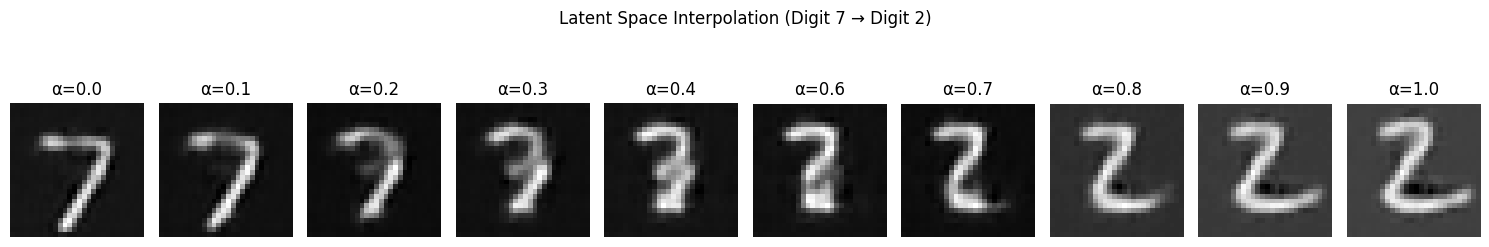


Generating random samples...


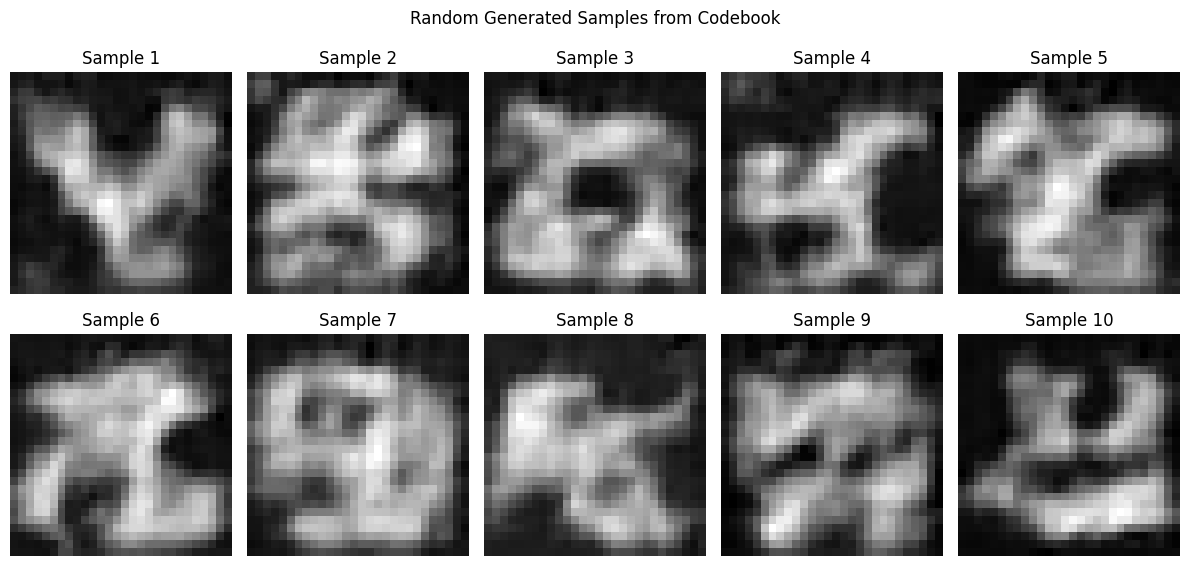

In [38]:
def interpolate_latent_space(model, test_loader, device, steps=10):
    """Interpolate between two images in the quantized latent space"""
    model.eval()
    
    # Get two random test images
    data, labels = next(iter(test_loader))
    img1, img2 = data[0:1].to(device), data[1:2].to(device)
    
    with torch.no_grad():
        # Encode both images
        z1 = model.encode(img1)
        z2 = model.encode(img2)
        
        # Create interpolation
        interpolated_images = []
        
        for i in range(steps):
            alpha = i / (steps - 1)
            # Linear interpolation in latent space
            z_interp = (1 - alpha) * z1 + alpha * z2
            
            # Decode interpolated latent
            img_interp = model.decode(z_interp)
            interpolated_images.append(img_interp.cpu().squeeze())
    
    # Visualize interpolation
    fig, axes = plt.subplots(1, steps, figsize=(15, 3))
    for i, img in enumerate(interpolated_images):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'α={i/(steps-1):.1f}')
        axes[i].axis('off')
    
    plt.suptitle(f'Latent Space Interpolation (Digit {labels[0]} → Digit {labels[1]})')
    plt.tight_layout()
    plt.show()

def generate_random_samples(model, device, num_samples=10):
    """Generate random samples by using random codebook vectors"""
    model.eval()
    
    with torch.no_grad():
        # Create random latent codes by sampling from the codebook
        batch_size = num_samples
        height, width = 7, 7  # Latent space dimensions
        embedding_dim = model.vq_layer.embedding_dim
        
        # Sample random codebook indices
        random_indices = torch.randint(0, model.vq_layer.num_embeddings, 
                                     (batch_size, height, width)).to(device)
        
        # Get corresponding embeddings
        random_codes = model.vq_layer.embedding(random_indices)
        
        # Reshape to proper format for decoder: (B, H, W, C) -> (B, C, H, W)
        random_latents = random_codes.permute(0, 3, 1, 2)
        
        # Decode to generate images
        generated_images = model.decode(random_latents)
    
    # Visualize generated samples
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
            ax.set_title(f'Sample {i+1}')
        ax.axis('off')
    
    plt.suptitle('Random Generated Samples from Codebook')
    plt.tight_layout()
    plt.show()

# Perform latent space interpolation
print("Performing latent space interpolation...")
interpolate_latent_space(model, test_loader, device)

# Generate random samples
print("\nGenerating random samples...")
generate_random_samples(model, device)

In [ ]:
def analyze_compression(model, test_loader, device):
    """Analyze the compression achieved by the VQ-VAE"""
    model.eval()
    
    # Original image dimensions
    original_size = 28 * 28  # pixels per image
    
    # Latent representation dimensions
    latent_height, latent_width = 7, 7  # from encoder output
    codebook_size = model.vq_layer.num_embeddings
    
    # Bits needed to represent each latent position
    bits_per_position = np.log2(codebook_size)
    
    # Total bits for latent representation
    latent_bits = latent_height * latent_width * bits_per_position
    
    # Compression ratio
    compression_ratio = original_size * 8 / latent_bits  # assuming 8 bits per pixel originally
    
    print("Compression Analysis:")
    print("-" * 40)
    print(f"Original image size: {original_size} pixels")
    print(f"Latent representation: {latent_height} × {latent_width} positions")
    print(f"Codebook size: {codebook_size} vectors")
    print(f"Bits per latent position: {bits_per_position:.2f}")
    print(f"Total latent bits: {latent_bits:.2f}")
    print(f"Compression ratio: {compression_ratio:.2f}:1")
    print(f"Compression percentage: {100/compression_ratio:.1f}% of original size")
    
    # Calculate actual reconstruction quality
    total_mse = 0
    total_samples = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_data, _, _ = model(data)
            
            mse = F.mse_loss(recon_data, data, reduction='sum')
            total_mse += mse.item()
            total_samples += data.size(0)
    
    avg_mse = total_mse / total_samples
    avg_psnr = 10 * np.log10(1.0 / avg_mse) if avg_mse > 0 else float('inf')
    
    print(f"\nReconstruction Quality:")
    print(f"Average MSE: {avg_mse:.6f}")
    print(f"Average PSNR: {avg_psnr:.2f} dB")

# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'perplexities': perplexities,
    'num_embeddings': model.vq_layer.num_embeddings,
    'embedding_dim': model.vq_layer.embedding_dim,
    'commitment_cost': model.vq_layer.commitment_cost,
}, 'vqvae_mnist_model.pth')

print("Model saved as 'vqvae_mnist_model.pth'")

# Analyze compression
analyze_compression(model, test_loader, device)

Model saved as 'vqvae_mnist_model.pth'
Compression Analysis:
----------------------------------------
Original image size: 784 pixels
Latent representation: 7 × 7 positions
Codebook size: 512 vectors
Bits per latent position: 9.00
Total latent bits: 441.00
Compression ratio: 14.22:1
Compression percentage: 7.0% of original size

Reconstruction Quality:
Average MSE: 12.026633
Average PSNR: -10.80 dB

Reconstruction Quality:
Average MSE: 12.026633
Average PSNR: -10.80 dB
